# Part 3C: Using LMFit

We have been using the uncertainties package to fit the linear Erying plot and the non-linear Erying equation to obtain thermodynamic data for the transition state of a reaction. The ```scipy.optimize.curve_fit``` tool cannot use the ufloat values provided by the uncertainties packagae and so we separated the nominal values and the standard deviations before using them in the curve fit.

There are many curve fitting packages available and one is *LMFit*. This package uses the uncertainties ufloat values natively. If we used it just like ```curve_fit``` we would obtain uncertain values for our parameters directly, with covariance already included. We still need to use the y values and y-error values separately but, after that, the output includes ufloat values natively.  It can also handle complex numbers and has built-in tools for data anaylsis and plotting.

## Load the Toolbox

In a *Python* notebook, we can mix code and text. In the code block below are commands to load the libraries and modules we will need for this exercise. There are some special commands that are used to run unix xommands directly in the terminal of *Colab* to install *Python* packages that are not available by default. These can "commented out" if you run this notebook on your own computer. You will need to add the "hashtag" comment symbol. 

In [1]:
### Setup environment

!mkdir plots

### Install and load packages
 
!pip install uncertainties     # uncomment to install dependancy
!pip install lmfit             # for docs see https://lmfit.github.io/lmfit-py/


import lmfit
import numpy as np                    # import the tools of NumPy as "np"
from matplotlib import pyplot as plt  # tools for plotting
import scipy.constants

import uncertainties as un               # tool set for uncertain numbers
from uncertainties import unumpy as unp  # a replacement for numpy

### Set global variables

#location_data = "data/"         ## Use either local folder or github folder. 
#location_styles = "styles/"     ## Use github locations for Colab
location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

plt.rcdefaults()

size = [4,4]
size2 = [4,5]
size3 = [2.5,2.5]


mkdir: plots: File exists


## Perform the Curve Fit

In the code below we start with the experimental results and then construct an array of ufloat values for the rate constants, $k$. This will allow us to use the uncertainties package to properly propagate errors through the $\ln(k/T)$ term for the y-axis. We then separate the nominal and error component of the y-axis values to give the $x$, $y$ and $y$-error values for the curve fit.

To use *LMFit* we must first create a model object using the ```lmfit.model``` function. Then we assign parameters and initial values to that model using ```lmfit.make_params```. Finally we optimize those parameters using a curve fit by calling the ```lmfit.fit``` function and assigning the bresult to a variable name.  This new variable now contains an lmfit object that contains the results and many tools for interpretting that information.

### Set Up the Data

Below we obtain the $x$, $y$ and $y$-error values for the linear Eyring plot.

In [2]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

### The Curve Fit

Below we use the ```lmfit.fit``` function to produce an object that contains the optimized parameters and much more.

In [3]:
######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=-1  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   



### Extract Results and Print Report

Now we call the ```fit_report``` function built into the result object. It will output lots of information about the fit. We then extract the slope and intercept as uncertain values and calculate the $\Delta H^\ddagger$ and $\Delta S^\ddagger$ values. Compare these to the results from ```scipy.optimize.curve_fit```. They should be identical because both systems use the least squares algorithm. You will see that the calculation of $k_{cat}$ at a given temperature produces a good value showing that the covariance between $\Delta H^\ddagger$ and $\Delta S^\ddagger$  is included in their respective ufloat values.

In [4]:
print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

Temp = 303
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")



---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 8.03472275
    reduced chi-square = 2.67824092
    Akaike info crit   = 6.37167291
    Bayesian info crit = 5.59054873
    R-squared          = 0.99382103
[[Variables]]
    m: -5545.86259 +/- 277.775827 (5.01%) (init = -1000)
    b:  15.3123516 +/- 0.91797561 (6.00%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9999
RSQ = 0.994

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 m:-2560.79881-918.55590-332.46919-5545.86259+332.46919+918.55590+2560.79881
 b:  -8.46276  -3.03558  -1.09872  15.31235  +1.09872  +3.03558  +8.46276
------THERMODYNAMIC PARAMETERS----------
The change in enthalpy is 46110.87+/-2309.56 J/mole
The change in entropy is -70.24+/-7.63 J/mole.K

-------- CHECK FIT ----------
calculate k a

### Plot the Fit

Now we will plot the data and the line representing the optimized parameters. Observe the complicated code for doing so. What do you think?

LMFit result objects contain many tool like this all-in-one plotting function that uses the data and parameters that are contained within the result object.

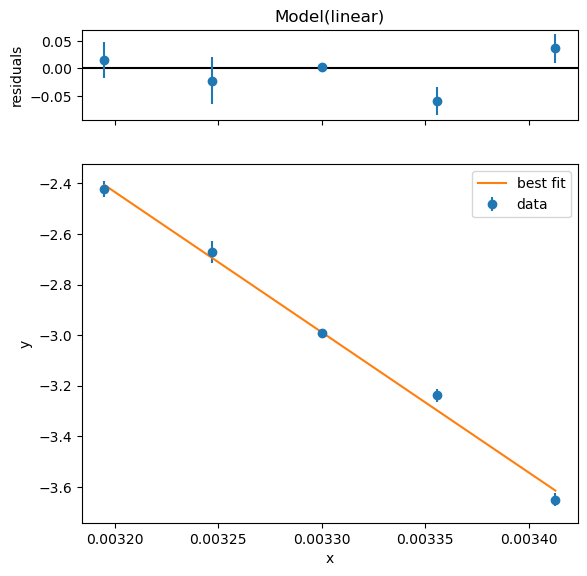

In [5]:
plt.rcdefaults()

result.plot()   # This method is built in to the 'result' object. 
                #   It plots the data, line-fit and residuals in one go.

plt.savefig("plots/3C-01.pdf")
plt.show()

### Adding the Confidence Band

Observe how we use the ```eval_uncertainty``` that is built in to the result object to calculate the standard deviation at each data point. We then use that to calculate the confidence band at $2\sigma$.

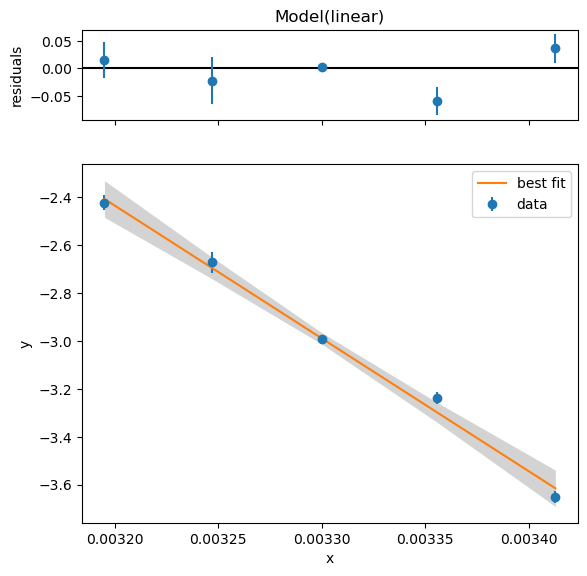

In [6]:
sigma = 2
result.plot()           # plot the data, the line and the residual plot

dely = result.eval_uncertainty(x=x)    # Evaluate uncertainty at all x-values

# Plot confidence interval
y_fit = result.best_fit
plt.fill_between(x, y_fit - dely*sigma, y_fit + dely*sigma, 
                 linewidth=0, color='lightgray', zorder=1)

plt.savefig("plots/3C-02.pdf")
plt.show()

### Fancy Styling

We can access style options within the built in plotting function of the result object. Observe how we do this using dictionaries. There are three blocks of code below. The first plots the fit with residuals, the second is just the fit and the last is just the residuals.

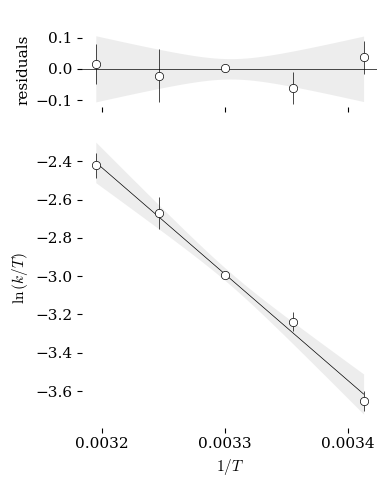

In [7]:
plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

fig = plt.figure(figsize = size2)
result.plot(fig = fig,
            fig_kws = {},      # this is a keyword dictionary for figure styles
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = " ",
            data_kws ={"color":"black", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", 
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            ax_res_kws = {},   # 'kws' is 'keyword styles'
            ax_fit_kws = {},
            )
 
ax = fig.axes   # get the axes from the plot (there are two in a list)

ax[1].set_xticks([0.0032,0.0033,0.0034]) # These will be the ticks for both axes

### Confidence band
sigma = 2

x_0 = np.linspace(np.min(x), np.max(x), 100)
y_0 = result.eval(x=x_0)
dely = result.eval_uncertainty(x=x)
dely_0 = result.eval_uncertainty(x=x_0, sigma=sigma)

ax[1].fill_between(x_0, y_0-dely_0, y_0+dely_0, 
                   linewidth=0, color='lightgray', alpha = 0.4, zorder=1
                   )
ax[0].fill_between(x_0, -dely_0, dely_0, 
                   linewidth=0, color='lightgray', alpha = 0.4, zorder=1
                   )

### do not show legend 
#fig.legend([])
ax[1].legend([])      # blank legend

plt.savefig("plots/3C-03.pdf")
plt.show()


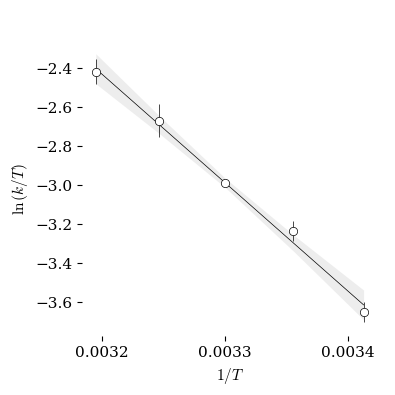

In [8]:
sigma = 2

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig = plt.figure(figsize = size)
result.plot_fit(
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = " ",
            data_kws ={"color":"k", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", 
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            )

plt.xticks([0.0032,0.0033,0.0034])  # These will be the ticks for both axes

### Confidence band
dely = result.eval_uncertainty(x=x)
plt.fill_between(x, result.best_fit-sigma*dely, result.best_fit+sigma*dely, 
                 linewidth=0, color='lightgray', alpha=0.4, zorder=1)

### do not show legend 
fig.legend([])
plt.legend([])      # blank legend

plt.savefig("plots/3C-04.pdf")
plt.show()



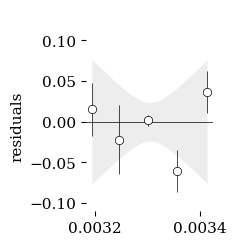

In [9]:
plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig = plt.figure(figsize = size3)

x_0 = np.linspace(np.min(x), np.max(x), 100)
dely = result.eval_uncertainty(x=x_0)


result.plot_residuals(
            yerr = y_err,
            title = " ",
            data_kws ={"color":"k", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", 
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            )

plt.fill_between(x_0, -sigma*dely, sigma*dely, 
                   linewidth=0, color='lightgray', alpha=0.4, zorder=1
                   )

plt.xticks([0.0032,0.0034])  # These will be the ticks for both axes
plt.ylim(-0.11,0.1)
### do not show legend 
fig.legend([])
plt.legend([])      # blank legend


plt.savefig("plots/3C-05.pdf")
plt.show()


## Plots of $k$ vs. $T$

We can repeat all of the above for the direct curve fit to the Erying equation. Observe how little we had to change to accomplish this.

---------- FIT REPORT ------------
[[Model]]
    Model(eyring)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 5
    # variables        = 2
    chi-square         = 7.76258442
    reduced chi-square = 2.58752814
    Akaike info crit   = 6.19938705
    Bayesian info crit = 5.41826288
    R-squared          = 0.99611341
[[Variables]]
    dH:  46263.7654 +/- 2237.04932 (4.84%) (init = 1000)
    dS: -69.7357517 +/- 7.39184495 (10.60%) (init = -50)
[[Correlations]] (unreported correlations are < 0.100)
    C(dH, dS) = +0.9999
RSQ = 0.983

RSQ = 0.991
RSQ = 0.983

------THERMODYNAMIC PARAMETERS----------
The change in enthalpy is 46263.77+/-2237.05 J/mole
The change in entropy is -69.74+/-7.39 J/mole.K

-------- CHECK FIT ----------
calculate k at T=303 K is 15.22+/-0.15


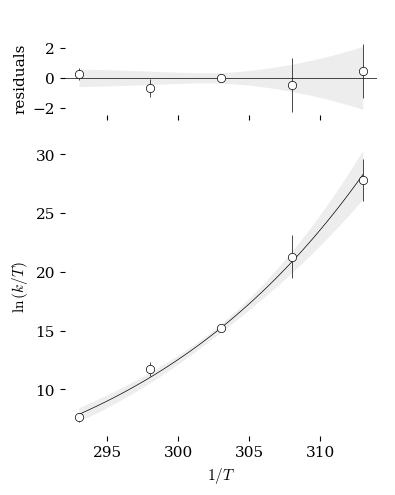

In [10]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = temp
y_u = k_obs   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats




######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

######################
###  Function to be used by curve_fit
######################
def eyring(x, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * x * np.exp(-dH/(R*x)) * np.exp(dS/R)
    return y

def eyring_u(x, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * x * unp.exp(-dH/(R*x)) * unp.exp(dS/R)
    return y


### Use LMFit curvevfit function  

mod = lmfit.Model(eyring)         # load the function f as the model to be fit

# state the parameters (use the text strings that we 
# used above in the function) initial values are also set here
pars = mod.make_params(dH  =1000, dS = -50  )     
                                                  
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, 
                 weights=1.0/y_err
                 )   



######################
###  Extract Results and print report
######################
print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

correlation = np.corrcoef(x, y)[0,1]
print(f"RSQ = {correlation:0.3f}")
print(f"RSQ = {correlation**2:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
#print(result.ci_report())
#print()

dH = result.uvars['dH']         # collect parameters as uncertain values 
dS = result.uvars['dS']

Temp = 303
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")
print()
## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")


sigma = 2

######################
###  Make the plot
######################

plt.rcdefaults()

plt.style.use(location_styles + "tufte.mplstyle")


fig = plt.figure(figsize = size2)
result.plot(fig = fig,
            numpoints = 100,
            fig_kws = {},      # this is a keyword dictionary for figure styles
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = sigma * y_err,
            title = " ",
            datafmt='o', fitfmt='-',
            data_kws ={
                       "color":"k", "linestyle":"None", "linewidth": 0.5,
                       "markersize":6, "markerfacecolor": "white", 
                       "markeredgecolor":"black", "markeredgewidth":0.5, 
                       "zorder":3
                       },
            fit_kws ={"linewidth": 0.5, "zorder":2},
            ax_res_kws = {},   
            ax_fit_kws = {
                        #  "xlim": [290,320], 
                        #  "xmargin": 0.05, "ymargin": 0.05, 
                        #  "xticks": [300,305,315]
                          },
            )

ax = fig.axes   # get the axes from the plot (there are two in a list)

### Confidence band

x_0 = np.linspace(np.min(x), np.max(x), 100)
y_0 = result.eval(x=x_0)
dely = result.eval_uncertainty(x=x_0, sigma=1)
dely_q = result.eval_uncertainty(x=x_0, sigma=sigma)


ax[1].fill_between(x_0, result.eval(x=x_0)-sigma*dely, result.eval(x=x_0)+sigma*dely, 
                   linewidth=0, color='lightgray', alpha=0.4, zorder=1)
#ax[1].fill_between(x_0, result.eval(x=x_0)-dely_q, result.eval(x=x_0)+dely_q, 
#                   linewidth=0, color='pink', alpha=0.4, zorder=1)

dely = result.eval_uncertainty(x=x_0, sigma=1)
dely_q = result.eval_uncertainty(x=x_0, sigma=sigma)

ax[0].fill_between(x_0, -sigma*dely, sigma*dely, 
                   linewidth=0, color='lightgray', alpha = 0.4, zorder=1
                   )

#ax[0].fill_between(x_0, -dely_q, dely_q, 
#                   linewidth=0, color='pink', alpha = 0.4, zorder=1
#                   )

### do not show legend 
fig.legend([])
ax[1].legend([])      # blank legend

plt.tight_layout()
plt.savefig("plots/3C-06.pdf")
plt.show()



## Which Do You Prefer?

The ```scipy.stats.linregress``` function was useful but did not output information that allowed simple creation of uncertain values for the parameters that included covariance. Using ```scipy.optimize.curve_fit``` will allow us to fit to any arbitrary equation and produced a covariance matrix that allows for the creation of properly correlated uncertain values for the parameters. The ```lmfit.fit``` function produced correlated uncertain values for the fit parameters directly and also has many tools builtin for analysis and plotting.

The *LMFit* package is very powerful and I use it when I have a challenging situation like a function that includes imaginary numbers. The `curve fit` function is also powerful and just as good in most cases. Personal preference will help you choose.